<h1>Import</h1>

In [1]:
# Training in Kaggle by Hung Anh
# Link kaggle notebook: https://www.kaggle.com/hnganhlnguyn/ex3-cnn
# Link dataset https://www.kaggle.com/hnganhlnguyn/bird-dataset
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import Sequential,Model
from tensorflow.keras.layers import Conv2D,MaxPooling2D,Flatten,Dense,Dropout,BatchNormalization,SeparableConv2D,Activation,GlobalAveragePooling2D,Add
import numpy as np
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.callbacks import EarlyStopping,ModelCheckpoint, ReduceLROnPlateau
from tensorflow.keras.layers.experimental.preprocessing import Rescaling,Resizing
import time
#AUTOTUNE = tf.data.experimental.AUTOTUNE

In [2]:
!nvidia-smi

Wed Nov 10 07:15:43 2021       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 450.119.04   Driver Version: 450.119.04   CUDA Version: 11.0     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla P100-PCIE...  Off  | 00000000:00:04.0 Off |                    0 |
| N/A   43C    P0    26W / 250W |      0MiB / 16280MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

<h1>Prepare Data and Parameters</h1>

In [3]:
# Set batch size
#BATCH_SIZE = 8 * strategy.num_replicas_in_sync
BATCH_SIZE = 32

# Set number of epochs
EPOCHS = 500

# Patience for the learning rate
LR_PATIENCE = 5

# Patience for early stopping
STOPPING_PATIENCE = 30

In [4]:
train_directory = '../input/bird-dataset/Bird_DataClassification/Train'
valid_directory = '../input/bird-dataset/Bird_DataClassification/Valid'
test_directory = '../input/bird-dataset/Bird_DataClassification/Test'

In [5]:
train_ds = tf.keras.preprocessing.image_dataset_from_directory(train_directory,seed=123,validation_split=0.1,subset="training",image_size=(256,256),batch_size=BATCH_SIZE)

Found 2010 files belonging to 2 classes.
Using 1809 files for training.


2021-11-10 07:15:44.617152: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2021-11-10 07:15:44.732294: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2021-11-10 07:15:44.733615: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2021-11-10 07:15:44.737413: I tensorflow/core/platform/cpu_feature_guard.cc:142] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags

In [6]:
valid_ds = tf.keras.preprocessing.image_dataset_from_directory(valid_directory,seed=13,validation_split=0.95,subset="validation",image_size=(256,256),batch_size=BATCH_SIZE)

Found 603 files belonging to 2 classes.
Using 572 files for validation.


In [7]:
test_ds = tf.keras.preprocessing.image_dataset_from_directory(test_directory,seed=123,image_size=(256,256),batch_size=BATCH_SIZE)

Found 739 files belonging to 2 classes.


<h1>Visualize samples</h1>

2021-11-10 07:15:47.634045: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:185] None of the MLIR Optimization Passes are enabled (registered 2)


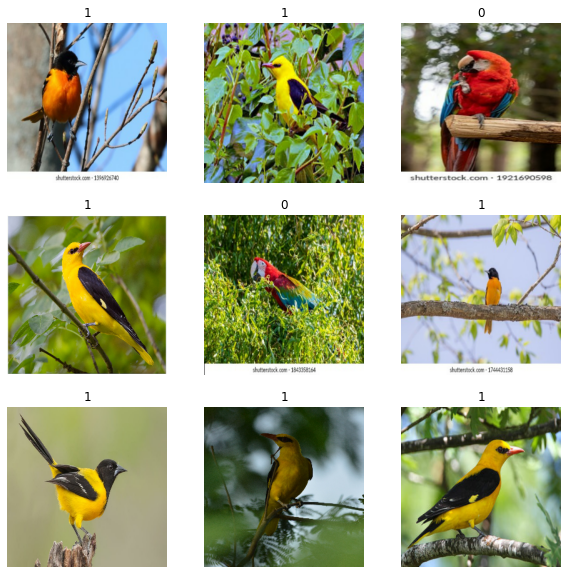

In [8]:
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 10))
for images, labels in train_ds.take(1):
    for i in range(9):
        ax = plt.subplot(3, 3, i + 1)
        plt.imshow(images[i].numpy().astype("uint8"))
        plt.title(int(labels[i]))
        plt.axis("off")

<h1>Augmentation</h1>

In [9]:
data_augmentation = tf.keras.Sequential([
    tf.keras.layers.experimental.preprocessing.RandomFlip("horizontal"),
    tf.keras.layers.experimental.preprocessing.RandomRotation(0.1)])

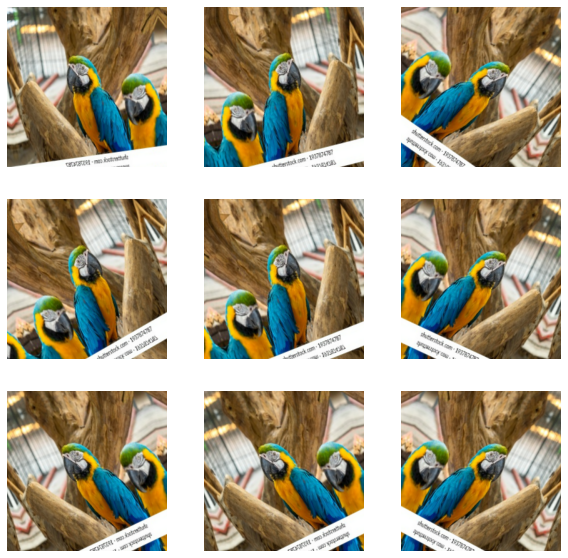

In [10]:
plt.figure(figsize=(10, 10))
for images, _ in train_ds.take(1):
    for i in range(9):
        augmented_images = data_augmentation(images)
        ax = plt.subplot(3, 3, i + 1)
        plt.imshow(augmented_images[0].numpy().astype("uint8"))
        plt.axis("off")

<h1>Build and Train model</h1>

In [11]:
def classifier_model(input_shape = (256,256,3), num_classes = 2):
    inputs = tf.keras.Input(shape=input_shape)
    # Image augmentation block
    x = data_augmentation(inputs)

    # Entry block
    x = Rescaling(1.0/ 255)(x)
    x = Conv2D(32, 3, strides=2, padding="same")(x)
    x = BatchNormalization()(x)
    x = Activation("relu")(x)

    x = Conv2D(64, 3, padding="same")(x)
    x = BatchNormalization()(x)
    x = Activation("relu")(x)

    previous_block_activation = x  # Set aside residual
    for size in [128, 256, 512, 728]:
        x = Activation("relu")(x)
        x = SeparableConv2D(size, 3, padding="same")(x)
        x = BatchNormalization()(x)

        x = Activation("relu")(x)
        x = SeparableConv2D(size, 3, padding="same")(x)
        x = BatchNormalization()(x)

        x = MaxPooling2D(3, strides=2, padding="same")(x)

        # Project residual
        residual = Conv2D(size, 1, strides=2, padding="same")(previous_block_activation)
        x = Add()([x, residual])  # Add back residual
        previous_block_activation = x  # Set aside next residual

    x = SeparableConv2D(1024, 3, padding="same")(x)
    x = BatchNormalization()(x)
    x = Activation("relu")(x)

    x = GlobalAveragePooling2D()(x)
    if num_classes == 2:
        activation = "sigmoid"
        units = 1
    else:
        activation = "softmax"
        units = num_classes

    x = Dropout(0.5)(x)
    outputs = Dense(units, activation=activation)(x)
    return Model(inputs, outputs)

In [12]:
classifier1 = classifier_model(input_shape = (256,256,3), num_classes=2)
loss = 'binary_crossentropy'
metrics=['accuracy']
classifier1.compile(optimizer='adam',loss=loss,metrics=metrics)

In [13]:
classifier1.summary()

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 256, 256, 3) 0                                            
__________________________________________________________________________________________________
sequential (Sequential)         (None, 256, 256, 3)  0           input_1[0][0]                    
__________________________________________________________________________________________________
rescaling (Rescaling)           (None, 256, 256, 3)  0           sequential[0][0]                 
__________________________________________________________________________________________________
conv2d (Conv2D)                 (None, 128, 128, 32) 896         rescaling[0][0]                  
______________________________________________________________________________________________

In [14]:
learning_rate = ReduceLROnPlateau(patience=LR_PATIENCE,verbose=1,factor=0.5,min_delta=0.000001)
early_stopping = EarlyStopping(patience=STOPPING_PATIENCE,monitor='val_loss',verbose=1,restore_best_weights=True,mode='min')

In [15]:
pre_train = time.time()
history = classifier1.fit(train_ds,validation_data=valid_ds,epochs=EPOCHS,callbacks=[learning_rate,early_stopping])
time_training = time.time() - pre_train

Epoch 1/500


2021-11-10 07:15:58.677378: I tensorflow/stream_executor/cuda/cuda_dnn.cc:369] Loaded cuDNN version 8005


57/57 [==============================] - 35s 429ms/step - loss: 0.4079 - accuracy: 0.8209 - val_loss: 0.7139 - val_accuracy: 0.3339
Epoch 2/500
57/57 [==============================] - 23s 386ms/step - loss: 0.2432 - accuracy: 0.9049 - val_loss: 0.8505 - val_accuracy: 0.3339
Epoch 3/500
57/57 [==============================] - 23s 382ms/step - loss: 0.2009 - accuracy: 0.9176 - val_loss: 1.1366 - val_accuracy: 0.3339
Epoch 4/500
57/57 [==============================] - 23s 387ms/step - loss: 0.2056 - accuracy: 0.9215 - val_loss: 1.5020 - val_accuracy: 0.3339
Epoch 5/500
57/57 [==============================] - 23s 382ms/step - loss: 0.1641 - accuracy: 0.9348 - val_loss: 1.8565 - val_accuracy: 0.3339
Epoch 6/500
57/57 [==============================] - 23s 382ms/step - loss: 0.1416 - accuracy: 0.9491 - val_loss: 2.8264 - val_accuracy: 0.3339

Epoch 00006: ReduceLROnPlateau reducing learning rate to 0.0005000000237487257.
Epoch 7/500
57/57 [==============================] - 23s 381ms/step

<h1>Evaluation</h1>

In [16]:
print('Time training model: %.1f (s)'%(time_training))

Time training model: 1778.6 (s)


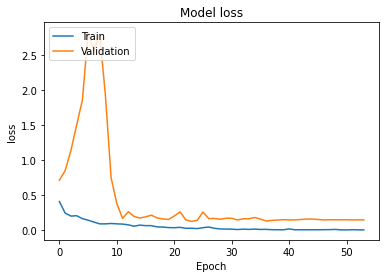

In [17]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model loss')
plt.ylabel('loss')
plt.xlabel('Epoch')
plt.legend(['Train','Validation'],loc='upper left')
plt.show()

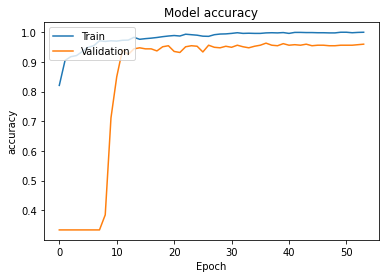

In [18]:
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model accuracy')
plt.ylabel('accuracy')
plt.xlabel('Epoch')
plt.legend(['Train','Validation'],loc='upper left')
plt.show()

In [19]:
classifier1.save('Ex3classifier1.h5')

/opt/conda/lib/python3.7/site-packages/keras/utils/generic_utils.py:497: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  category=CustomMaskWarning)


In [20]:
from tensorflow.keras.models import load_model
loadEx3_model = load_model('./Ex3classifier1.h5')

In [21]:
train_score = loadEx3_model.evaluate(train_ds)

57/57 [==============================] - 8s 107ms/step - loss: 0.0103 - accuracy: 0.9978


In [22]:
valid_score = loadEx3_model.evaluate(valid_ds)

18/18 [==============================] - 2s 72ms/step - loss: 0.1240 - accuracy: 0.9545


In [23]:
test_score = loadEx3_model.evaluate(test_ds)

24/24 [==============================] - 4s 124ms/step - loss: 0.1165 - accuracy: 0.9635


<h2>Nhận xét:</h2>
<li>Model hoạt động tốt trên tập giữ liệu với độ chính xác cao ở cả 3 tập</li>

In [24]:
new_url1 = 'https://sudospaces.com/gaocung-com/2021/01/chim-vang-anh-an-gi-1.jpg'
new_url2 = 'https://cdn.chotot.com/MfxqCZMCgcr-PqIvoOCcmP8VZGqZnWVpfbB_wl59QXM/preset:view/plain/5a0e729ef5c9265889ab6e0a6b86d68d-2745499794937820100.jpg'

In [25]:
f = open("../input/bird-dataset/Bird_DataClassification/info.txt", "r")
print(f.read()) # in ra bảng thông tin nhãn

0,vet
1,chim_vang_anh


In [26]:
from PIL import Image
import requests

def get_imgURL(url): 
    im = Image.open(requests.get(url, stream=True).raw)
    im = im.resize((256,256))
    img_array = np.asarray(im)
    img_array = tf.expand_dims(img_array,0)
    return img_array

In [27]:
img1 = get_imgURL(new_url1)
img1.shape

TensorShape([1, 256, 256, 3])

In [28]:
predictions1 = loadEx3_model.predict(img1)
score1 = predictions1[0]
print("This image is %.2f percent parrot and %.2f percent oriole."% (100 * (1 - score1), 100 * score1))

This image is 0.02 percent parrot and 99.98 percent oriole.


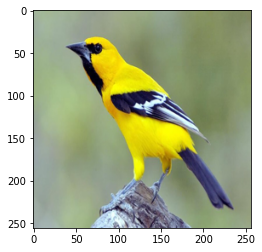

In [29]:
plt.imshow(img1[0]) # oriole

In [30]:
img2 = get_imgURL(new_url2)
img2.shape

TensorShape([1, 256, 256, 3])

In [31]:
predictions2 = loadEx3_model.predict(img2)
score2 = predictions2[0]
print("This image is %.2f percent parrot and %.2f percent oriole."% (100 * (1 - score2), 100 * score2))

This image is 98.68 percent parrot and 1.32 percent oriole.


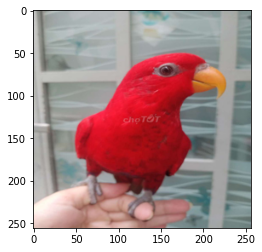

In [32]:
plt.imshow(img2[0]) # parrot